In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import prepare_inference_combined
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

In [2]:
blue = '#1F449C'
pink = '#E57A77'

## Comparing Combined / Conjugate for Poisson Constraints

In [54]:
model = pyhf.simplemodels.uncorrelated_background([120, 120], [10, 10], [120, 120])
data = [130, 130]
auxdata = model.config.auxdata

#### Conjugate

(19 s)

In [89]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=28_000, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Metropolis: [uncorr_bkguncrt]


/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 15 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


#### Combined

(26 s)

In [88]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=28_000, chains=1, step=step)
    post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained_Gammas]
>Metropolis: [Gammas]


Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 18 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_ActData, Expected_AuxData]


#### Comparison Posterior

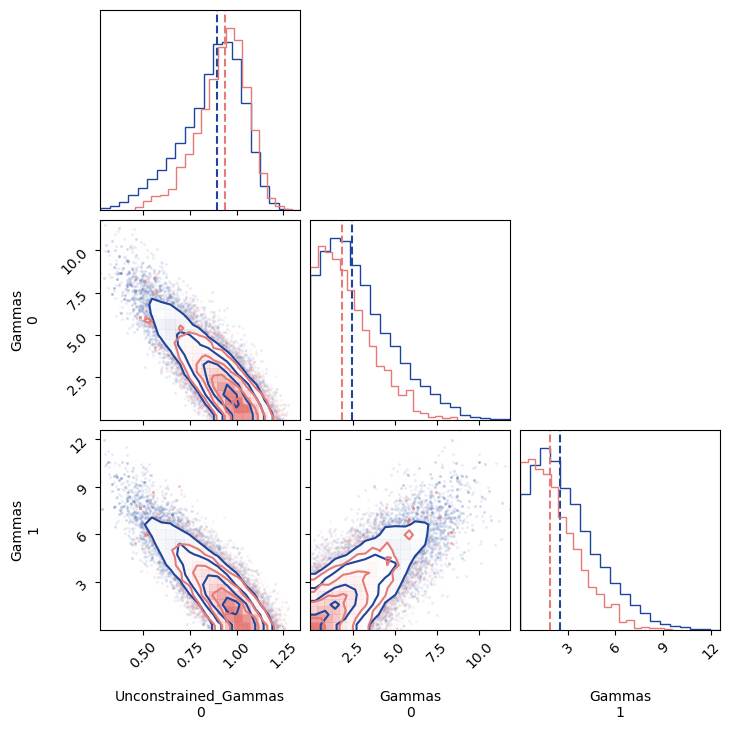

In [75]:
# HMC 14_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

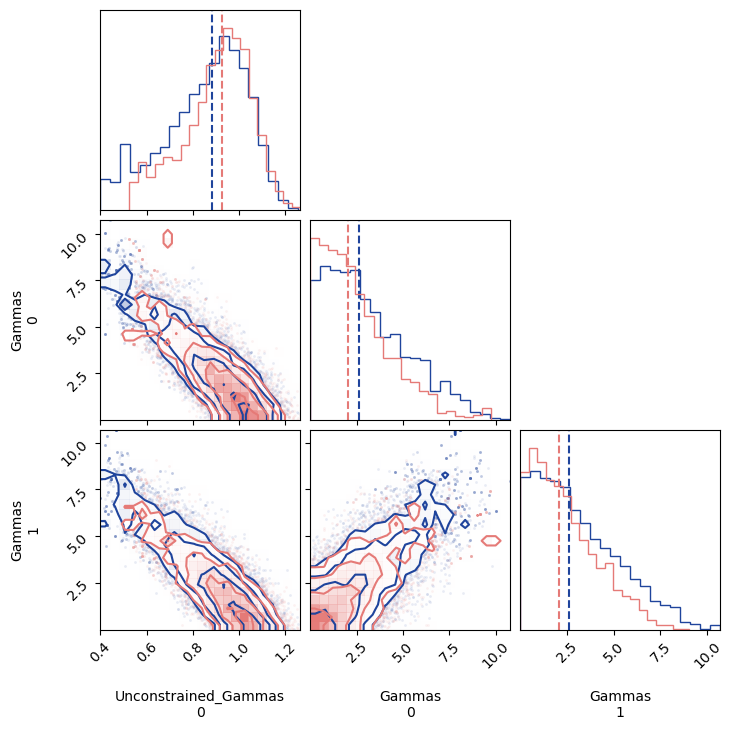

In [86]:
# HMC 8_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

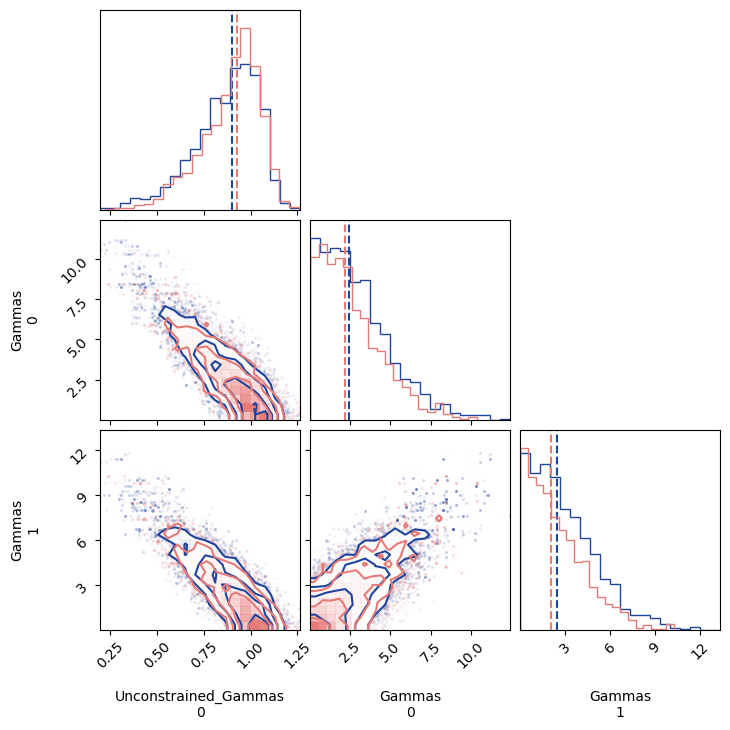

In [82]:
# Metropolis 8_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

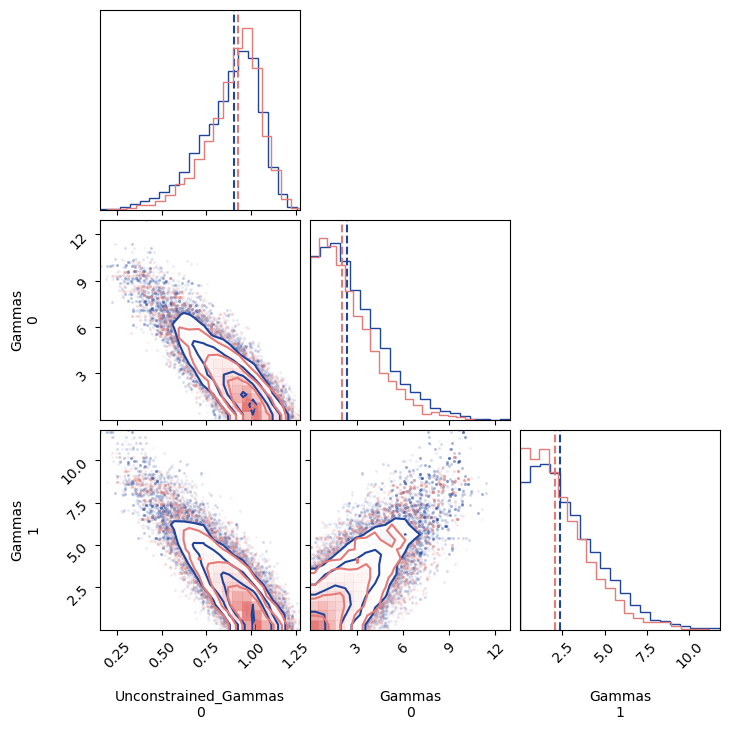

In [90]:
# Metropolis 28_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

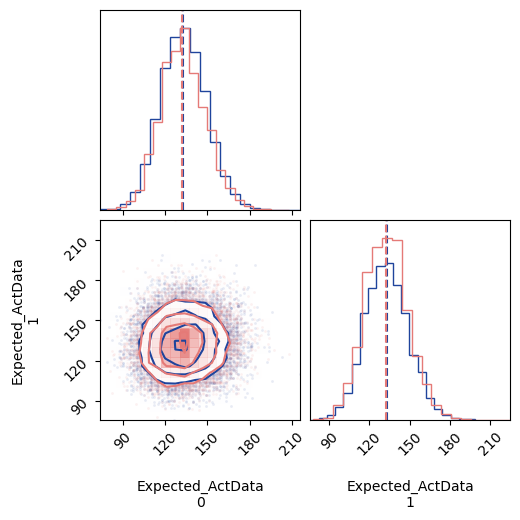

In [64]:
# HMC 14_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);

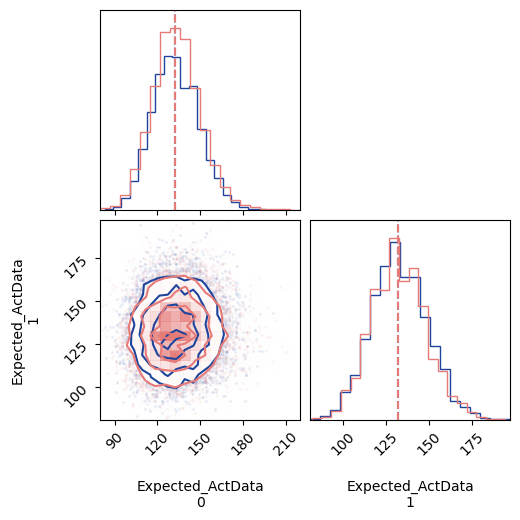

In [87]:
# HMC 8_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);

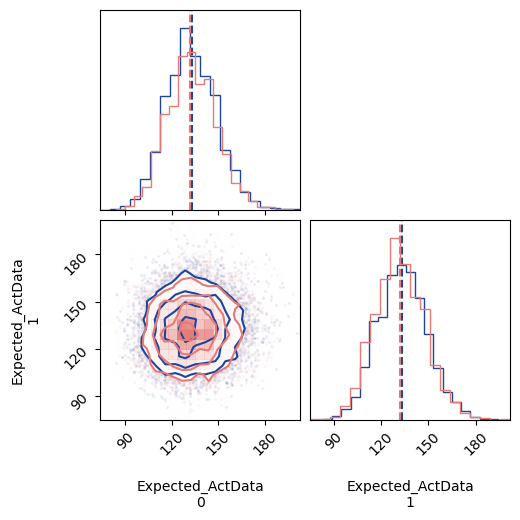

In [83]:
# Metropolis 8_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);

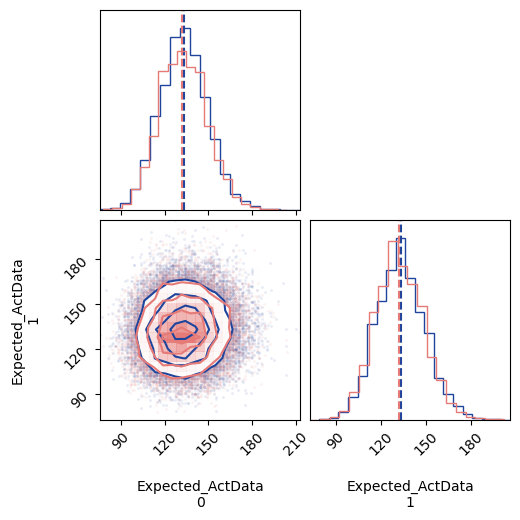

In [91]:
# Metropolis 28_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);

## Combined / Conjugate for Normal constraints

In [94]:
model = pyhf.simplemodels.correlated_background([120, 120], [10, 10], [130, 130], [110, 110])
data = [130, 130]
auxdata = model.config.auxdata

In [104]:
unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [5]},
    # 'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

#### Conjugate

In [105]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=28_000, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [correlated_bkg_uncertainty]
>Metropolis: [mu]


Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 13 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


#### Combined

(26 s)

In [106]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=28_000, chains=1, step=step)
    post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained_HalfNormals]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 15 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_ActData, Expected_AuxData]


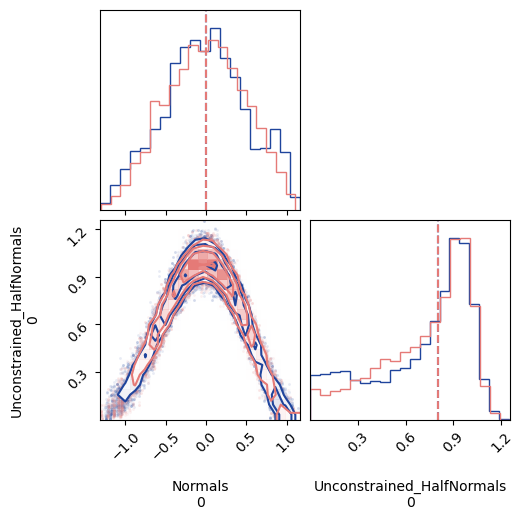

In [107]:
# Metropolis 28_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

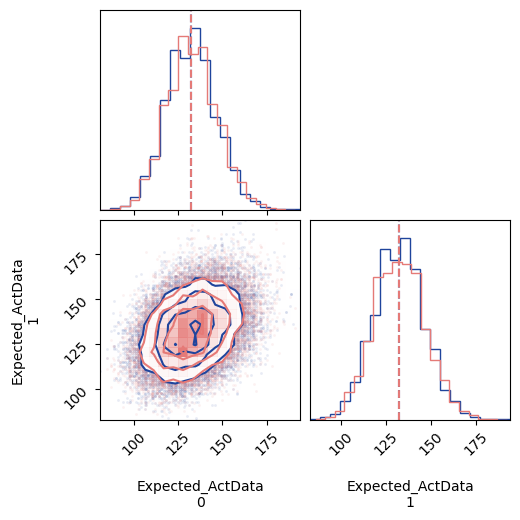

In [98]:
# Metropolis 28_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);

## Combined / Conjugate for Poisson and Normal constaints

In [108]:
model = pyhf.Model(
        {'channels': [{'name': 'singlechannel',
        'samples': [
        {'name': 'signal',
        'data': [10, 20],
        'modifiers': [
            {'name': 'mu', 'type': 'normfactor', 'data': None},
            # {'name': 'mu2', 'type': 'normfactor', 'data': None}
            ]},
        {'name': 'background',
        'data': [120, 110],
        'modifiers': [
            # Correlated / Normal
            {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [200, 190], 'lo_data': [90, 95]}},
            # Uncorrelated / Poisson
            {'name': 'uncorr_bkg', 'type': 'shapesys','data': [120, 120]}
            ]}]}]
            }
        )

data = [110, 105]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    #'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

In [109]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=28_000, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [corr_bkg]
>Metropolis: [mu]
>Metropolis: [uncorr_bkg]


Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 23 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


In [110]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=28_000, chains=1, step=step)
    post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained_Gammas]
>Metropolis: [Normals]
>Metropolis: [Gammas]


/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 28 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_ActData, Expected_AuxData]


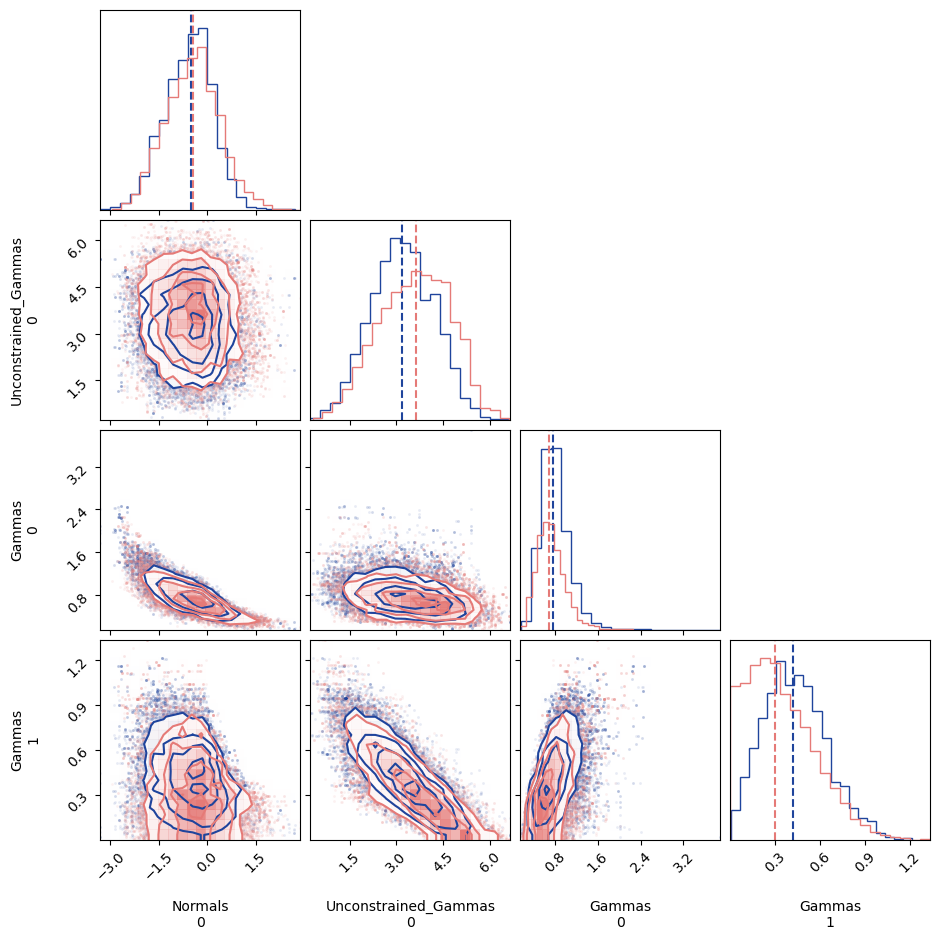

In [112]:
# Metropolis 28_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

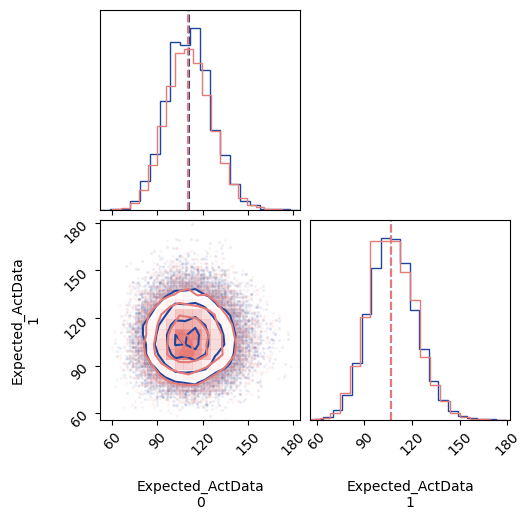

In [113]:
# Metropolis 28_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);